In [1]:
import torch
from manifm.eval_utils import load_model
from manifm.datasets import get_loaders, get_manifold
from manifm.model_pl import ManifoldAELitModule

device = "cuda"
flow_ckpt_path = "/home/yjang43/workspace/riemannian-fm/outputs/multiruns/fire/fm/2024.11.19/231101/1/checkpoints/last.ckpt" # flow
reflow_ckpt_path = "/home/yjang43/workspace/riemannian-fm/outputs/runs/reflow_fire/fm/2024.11.21/223550/checkpoints/last.ckpt" # reflow

In [9]:
def sample_path(ckpt_path, num_steps_list=[1000, 100, 10]):
    torch.manual_seed(3)
    cfg, pl_model = load_model(ckpt_path)
    pl_model.train(mode=False)
    pl_model.to(device)
    manifold, dim = get_manifold(cfg)
    x0 = manifold.random_base(1, dim)

    x_t_dict = {}
    for num_steps in num_steps_list:
        x_t = pl_model.sample_all(None, device, x0.to(device), num_steps=num_steps).cpu()
        x_t_dict[num_steps] = x_t

    return x_t_dict

flow_x_t_dict = sample_path(flow_ckpt_path)
reflow_x_t_dict = sample_path(reflow_ckpt_path)


diff 2: tensor(0.0015, device='cuda:0')
diff 2: tensor(0.0030, device='cuda:0')
diff 2: tensor(0.0045, device='cuda:0')
diff 2: tensor(0.0059, device='cuda:0')
diff 2: tensor(0.0074, device='cuda:0')
diff 2: tensor(0.0089, device='cuda:0')
diff 2: tensor(0.0103, device='cuda:0')
diff 2: tensor(0.0118, device='cuda:0')
diff 2: tensor(0.0132, device='cuda:0')
diff 2: tensor(0.0146, device='cuda:0')
diff 2: tensor(0.0160, device='cuda:0')
diff 2: tensor(0.0174, device='cuda:0')
diff 2: tensor(0.0188, device='cuda:0')
diff 2: tensor(0.0202, device='cuda:0')
diff 2: tensor(0.0216, device='cuda:0')
diff 2: tensor(0.0230, device='cuda:0')
diff 2: tensor(0.0244, device='cuda:0')
diff 2: tensor(0.0258, device='cuda:0')
diff 2: tensor(0.0271, device='cuda:0')
diff 2: tensor(0.0285, device='cuda:0')
diff 2: tensor(0.0298, device='cuda:0')
diff 2: tensor(0.0311, device='cuda:0')
diff 2: tensor(0.0325, device='cuda:0')
diff 2: tensor(0.0338, device='cuda:0')
diff 2: tensor(0.0351, device='cuda:0')


In [10]:
import numpy as np
import geopandas
from shapely.geometry import Point, LineString
from manifm.utils import lonlat_from_cartesian

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

def plot_earth2d(ax, samples, color="#d73027", zoom=False):

    # Plot model samples
    geometry = [Point(lonlat_from_cartesian(x) / np.pi * 180) for x in samples]
    pts = geopandas.GeoDataFrame(geometry=geometry)
    pts.plot(ax=ax, color=color, markersize=0.1, alpha=0.7)
    if zoom:
        # set max of x and y to be lim
        minx, miny, maxx, maxy = pts.total_bounds
        if ax.get_xlim()[1] - ax.get_xlim()[0] < 150:
            minx, maxx = min(minx, ax.get_xlim()[0]), max(maxx, ax.get_xlim()[1])
            miny, maxy = min(miny, ax.get_ylim()[0]), max(maxy, ax.get_ylim()[1])
        ax.set_xlim(minx-5, maxx+5)
        ax.set_ylim(miny-5, maxy+5)
    
    # Create LineStrings between consecutive points
    lines = [
        LineString([geometry[i], geometry[i + 1]]) for i in range(len(geometry) - 1)
    ]
    line_gdf = geopandas.GeoDataFrame(geometry=lines)

    # Plot lines connecting points
    line_gdf.plot(ax=ax, color=color, linewidth=0.5, alpha=0.5, label="_nolegend_")
    return ax

/tmp/ipykernel_3963370/1705730188.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


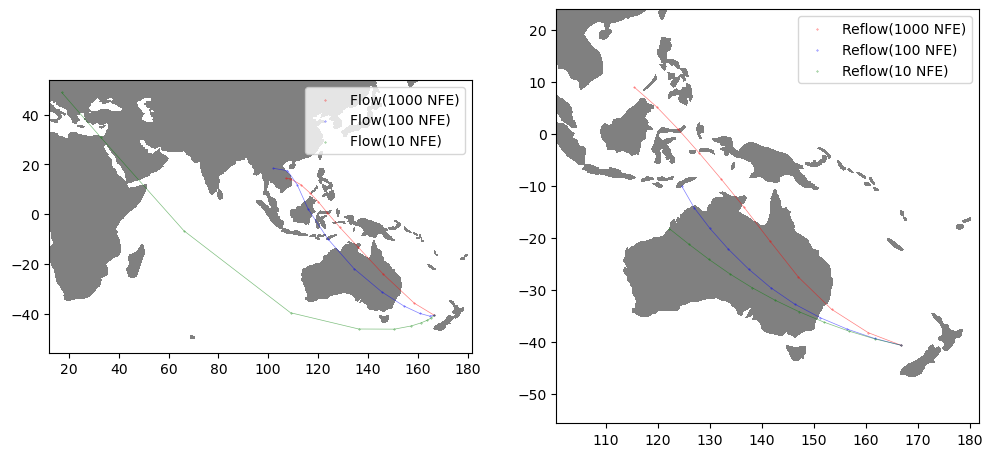

In [11]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax = world.plot(ax=axs[0], figsize=(6, 6), antialiased=False, color="grey")
plot_earth2d(ax, flow_x_t_dict[1000][::100], "red", zoom=True)
plot_earth2d(ax, flow_x_t_dict[100][::10], "blue", zoom=True)
plot_earth2d(ax, flow_x_t_dict[10], "green", zoom=True)
# plot_earth2d(ax, flow_x_t_dict[3000][::100], "red", zoom=True)
# plot_earth2d(ax, flow_x_t_dict[2000][::100], "blue", zoom=True)
# plot_earth2d(ax, flow_x_t_dict[1000][::100], "green", zoom=True)

ax.legend(["Flow(1000 NFE)", "Flow(100 NFE)", "Flow(10 NFE)"])

ax = world.plot(ax=axs[1], figsize=(6, 6), antialiased=False, color="grey")
plot_earth2d(ax, reflow_x_t_dict[1000][::100], "red", zoom=True)
plot_earth2d(ax, reflow_x_t_dict[100][::10], "blue", zoom=True)
plot_earth2d(ax, reflow_x_t_dict[10], "green", zoom=True)
# plot_earth2d(ax, reflow_x_t_dict[3000][::100], "red", zoom=True)
# plot_earth2d(ax, reflow_x_t_dict[2000][::100], "blue", zoom=True)
# plot_earth2d(ax, reflow_x_t_dict[1000][::100], "green", zoom=True)

ax.legend(["Reflow(1000 NFE)", "Reflow(100 NFE)", "Reflow(10 NFE)"])

